# Cifar Library and Demo

[This is a library](https://pkg.go.dev/github.com/gomlx/gomlx/examples/cifar) to download and parse the Cifar datasets (Cifar-10 and Cifar-100), and a very small demo of a FNN (Feedforward Neural Network) with GoMLX. FNNs are notoriously bad for images, but it's only a demo. Look for the Resnet50 model for a more serious image classification model (old but still good -- best results as of the time of this writing is with ViT model).

The CIFAR-10 and CIFAR-100 are labeled subsets of the 80 million tiny images dataset. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. See more details in [its homepage here](https://www.cs.toronto.edu/~kriz/cifar.html).

This notebook serves as documentation and example for the [github.com/gomlx/gomlx/examples/cifar](https://github.com/gomlx/gomlx/examples/cifar) library, and the demo code in one piece can be seen in [.../examples/cifar/demo/](https://github.com/gomlx/gomlx/tree/main/examples/cifar/demo)

## Environment Set Up

Let's set up `go.mod` to use the local copy of GoMLX, so it can be developed jointly the dataset code with the model. That's often how data pre-processing and model code is developed together with experimentation.

If you are not changing code, feel free to simply skip this cell. Or if you used a different directory for you projects, change it below.

Notice the directory `${HOME}/Projects/gomlx` is where the GoMLX code is copied by default in [its Docker](https://hub.docker.com/repository/docker/janpfeifer/gomlx_jupyterlab/general).

In [1]:
!*rm -f go.work && go work init && go work use . "${HOME}/Projects/gomlx" "${HOME}/Projects/gonb" "${HOME}/Projects/gopjrt" "${HOME}/Projects/bsplines"
%goworkfix

	- Added replace rule for module "github.com/gomlx/bsplines" to local directory "/home/janpf/Projects/bsplines".
	- Added replace rule for module "github.com/gomlx/gomlx" to local directory "/home/janpf/Projects/gomlx".
	- Added replace rule for module "github.com/janpfeifer/gonb" to local directory "/home/janpf/Projects/gonb".
	- Added replace rule for module "github.com/gomlx/gopjrt" to local directory "/home/janpf/Projects/gopjrt".


## Data Preparation

### Downloading data files

To download, uncompress and untar to the local directory, simply do the following. Notice if it's already downloaded in the given `--data` directory, it returns immediately.

In [2]:
import (
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/data"
    "github.com/janpfeifer/must"
)

var flagDataDir = flag.String("data", "~/work/cifar", "Directory to cache downloaded and generated dataset files.")

func AssertDownloaded() {
    *flagDataDir = data.ReplaceTildeInDir(*flagDataDir)
    if !data.FileExists(*flagDataDir) {
        must.M(os.MkdirAll(*flagDataDir, 0777))
    }

    must.M(cifar.DownloadCifar10(*flagDataDir))
    must.M(cifar.DownloadCifar100(*flagDataDir))
}

%%
AssertDownloaded()

In [3]:
!ls -lh ~/work/cifar/

total 44K
-rw-r--r-- 1 janpf janpf  358 Aug  2 10:32 a
-rw-r--r-- 1 janpf janpf 3.7K Aug  2 10:25 b
drwxr-x--- 2 janpf janpf 4.0K Aug  2 12:08 base_cnn_model
drwxr-x--- 2 janpf janpf 4.0K Aug  2 12:07 base_fnn_model
drwxr-xr-x 2 janpf janpf 4.0K Feb 20  2010 cifar-100-binary
drwxr-xr-x 2 janpf janpf 4.0K Jun  4  2009 cifar-10-batches-bin
drwxr-x--- 2 janpf janpf 4.0K Aug  2 09:51 cnn
drwxr-x--- 2 janpf janpf 4.0K Aug  1 17:28 cnn_layer
drwxr-x--- 2 janpf janpf 4.0K Jul 31 19:19 cnn_nonorm
drwxr-x--- 2 janpf janpf 4.0K Jul 31 08:28 fnn_batchnorm_0
drwxr-x--- 2 janpf janpf 4.0K Aug  1 14:24 fnn_layer


### Sample some images

The `cifar.NewDataset` creates a `data.InMemoryDataset` that can be used both for training, evaluation, or just to sample a few examples, which we do below:

Samples Cifar-10

automobile ([1]),ship ([8]),truck ([9]),truck ([9]),truck ([9]),airplane ([0]),ship ([8]),bird ([2])

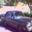
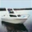
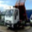
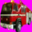
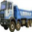
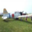
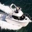
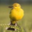

Samples Cifar-100

leopard ([42]),bowl ([10]),sea ([71]),ray ([67]),sweet_pepper ([83]),chimpanzee ([21]),tractor ([89]),tiger ([88])

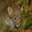
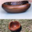
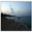
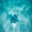
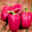
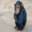
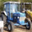
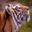

In [4]:
import (
    "strings"
    "github.com/gomlx/gopjrt/dtypes"
    "github.com/gomlx/gomlx/backends"
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/types/shapes"
    "github.com/gomlx/gomlx/types/tensors/images"
    "github.com/janpfeifer/gonb/gonbui"

    _ "github.com/gomlx/gomlx/backends/xla"
)

var (
    // Model DType, used everywhere.
    DType = dtypes.Float32
)

// sampleToNotebook generates a sample of Cifar-10 and Cifar-100 in a GoNB Jupyter Notebook.
func sampleToNotebook() {
    // Load data into tensors.
    backend := backends.New()
    ds10 := cifar.NewDataset(backend, "Samples Cifar-10", *flagDataDir, cifar.C10, DType, cifar.Train).Shuffle()
    ds100 := cifar.NewDataset(backend, "Samples Cifar-100", *flagDataDir, cifar.C100, DType, cifar.Train).Shuffle()
    sampleImages(ds10, 8, cifar.C10Labels)
    sampleImages(ds100, 8, cifar.C100FineLabels)
}

// sampleTable generates and outputs one html table of samples, sampling rows x cols from the images/labels provided.
func sampleImages(ds train.Dataset, numImages int, labelNames []string) {
    gonbui.DisplayHTML(fmt.Sprintf("<p>%s</p>\n", ds.Name()))
    
    parts := make([]string, 0, numImages+5) // Leave last part empty.
    parts = append(parts, "<table><tr>")
    for ii := 0; ii < numImages; ii++ {
        _, inputs, labels := must.M3(ds.Yield())
        imgTensor := inputs[0]
        img := images.ToImage().Single(imgTensor)
        label := labels[0].Value().([]int64)
        labelStr := labelNames[label[0]]
    
        imgSrc := must.M1(gonbui.EmbedImageAsPNGSrc(img))
        size := imgTensor.Shape().Dimensions[0]
        parts = append(
            parts, 
            fmt.Sprintf(`<td><figure style="padding:4px;text-align: center;"><img width="%d" height="%d" src="%s">` + 
                        `<figcaption style="text-align: center;">%s (%d)</figcaption></figure></td>`, 
                        size*2, size*2, imgSrc, labelStr, label),
        )
    }
    parts = append(parts, "</tr></table>", "")
    gonbui.DisplayHTML(strings.Join(parts, "\n"))
}

%%
AssertDownloaded()
sampleToNotebook()

## Training on Cifar-10

### Models Support

1. `flagModel` defines the model type, out of `validModels` options.
1. `createDefaultContex` creates a context and set the default values for the CIFAR models. 
1. `contextFromSettings` uses `createDefaultContext` and incorporate changes passed by the `-set` flag.


In [5]:
import (
    "flags"
    
    "github.com/gomlx/gomlx/ml/layers"
    "github.com/gomlx/gomlx/ml/layers/fnn"
    "github.com/gomlx/gomlx/ml/layers/kan"
    "github.com/gomlx/gomlx/ml/layers/regularizers"
    "github.com/gomlx/gomlx/ml/train/commandline"
    "github.com/gomlx/gomlx/ml/train/optimizers"
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/context"
)

var (
    // ValidModels is the list of model types supported.
    ValidModels = []string{"fnn", "kan", "cnn"}
	flagEval      = flag.Bool("eval", true, "Whether to evaluate the model on the validation data in the end.")
	flagVerbosity = flag.Int("verbosity", 1, "Level of verbosity, the higher the more verbose.")
)

// settings is bound to a "-set" flag to be used to set context hyperparameters.
var settings = commandline.CreateContextSettingsFlag(createDefaultContext(), "set")

// createDefaultContext sets the context with default hyperparameters
func createDefaultContext() *context.Context {
	ctx := context.New()
	ctx.RngStateReset()
	ctx.SetParams(map[string]any{
        // Model type to use: valid values are fnn, kan and cnn.
		"model":           cifar.C10ValidModels[0],
		"checkpoint":      "",
		"num_checkpoints": 3,
		"train_steps":     3000,

		// batch_size for training.
		"batch_size": 64,

		// eval_batch_size can be larger than training, it's more efficient.
		"eval_batch_size": 200,

		// "plots" trigger generating intermediary eval data for plotting, and if running in GoNB, to actually
		// draw the plot with Plotly.
		plotly.ParamPlots: true,

		// If "normalization" is set, it overrides "fnn_normalization" and "cnn_normalization".
		layers.ParamNormalization: "none",

		optimizers.ParamOptimizer:           "adamw",
		optimizers.ParamLearningRate:        1e-4,
		optimizers.ParamAdamEpsilon:         1e-7,
		optimizers.ParamAdamDType:           "",
		optimizers.ParamCosineScheduleSteps: 0,
		activations.ParamActivation:         "swish",
		layers.ParamDropoutRate:             0.0,
		regularizers.ParamL2:                1e-5,
		regularizers.ParamL1:                1e-5,

		// FNN network parameters:
		fnn.ParamNumHiddenLayers: 8,
		fnn.ParamNumHiddenNodes:  128,
		fnn.ParamResidual:        true,
		fnn.ParamNormalization:   "",   // Set to none for no normalization, otherwise it falls back to layers.ParamNormalization.
		fnn.ParamDropoutRate:     -1.0, // Set to 0.0 for no dropout, otherwise it falls back to layers.ParamDropoutRate.

		// KAN network parameters:
		kan.ParamNumControlPoints:   10, // Number of control points
		kan.ParamNumHiddenNodes:     64,
		kan.ParamNumHiddenLayers:    4,
		kan.ParamBSplineDegree:      2,
		kan.ParamBSplineMagnitudeL1: 1e-5,
		kan.ParamBSplineMagnitudeL2: 0.0,
		kan.ParamDiscrete:           false,
		kan.ParamDiscreteSoftness:   0.1,
	})
	return ctx
}

// ContextFromSettings is the default context (createDefaultContext) changed by -set flag.
func ContextFromSettings() *context.Context {
    ctx := createDefaultContext()
    must.M(commandline.ParseContextSettings(ctx, *settings))
    return ctx
}

// Let's test that we can set hyperparameters by setting it in the "-set" flag:
%% -set="batch_size=17;fnn_num_hidden_layers=12"
fmt.Printf("Model types: %q\n", cifar.C10ValidModels)
ctx := ContextFromSettings()
fmt.Println(commandline.SprintContextSettings(ctx))

Model types: ["fnn" "kan" "cnn"]
Context hyperparameters:
	"activation": (string) swish
	"adam_dtype": (string) 
	"adam_epsilon": (float64) 1e-07
	"batch_size": (int) 17
	"checkpoint": (string) 
	"cosine_schedule_steps": (int) 0
	"dropout_rate": (float64) 0
	"eval_batch_size": (int) 200
	"fnn_dropout_rate": (float64) -1
	"fnn_normalization": (string) 
	"fnn_num_hidden_layers": (int) 12
	"fnn_num_hidden_nodes": (int) 128
	"fnn_residual": (bool) true
	"kan_bspline_degree": (int) 2
	"kan_bspline_magnitude_l1": (float64) 1e-05
	"kan_bspline_magnitude_l2": (float64) 0
	"kan_discrete": (bool) false
	"kan_discrete_softness": (float64) 0.1
	"kan_num_hidden_layers": (int) 4
	"kan_num_hidden_nodes": (int) 64
	"kan_num_points": (int) 10
	"l1_regularization": (float64) 1e-05
	"l2_regularization": (float64) 1e-05
	"learning_rate": (float64) 0.0001
	"model": (string) fnn
	"normalization": (string) none
	"num_checkpoints": (int) 3
	"optimizer": (string) adamw
	"plots": (bool) true
	"train_steps": (in

### Simple FNN model

A trivial model, that can easily get to ~50% accuracy (a random model would do 10%), but hardly much more than that.

Later we are going to define a CNN model to compare, and we just set a placeholder model here for now.

> **Note**: 
>
> * The code is here just to exemplify. We are actually using the same code from the [`cifar`](https://github.com/gomlx/gomlx/tree/main/examples/cifar) package.

In [6]:
import (
    "flags"    
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/context"
    "github.com/gomlx/gomlx/ml/train/optimizers"
    "github.com/gomlx/gomlx/types/shapes"
)

var _ = NewGraph  // Make sure the graph package is in use.

// C10PlainModelGraph implements train.ModelFn, and returns the logit Node, given the input image.
// It's a basic FNN (Feedforward Neural Network), so no convolutions. It is meant only as an example.
func C10PlainModelGraph(ctx *context.Context, spec any, inputs []*graph.Node) []*graph.Node {
	ctx = ctx.In("model")
	batchedImages := inputs[0]
	batchSize := batchedImages.Shape().Dimensions[0]
	logits := graph.Reshape(batchedImages, batchSize, -1)
	numClasses := len(cifar.C10Labels)
	modelType := context.GetParamOr(ctx, "model", cifar.C10ValidModels[0])
	if modelType == "kan" {
		// Configuration of the KAN layer(s) use the context hyperparameters.
		logits = kan.New(ctx, logits, numClasses).Done()
	} else {
		// Configuration of the FNN layer(s) use the context hyperparameters.
		logits = fnn.New(ctx, logits, numClasses).Done()
	}
	logits.AssertDims(batchSize, numClasses)
	return []*graph.Node{logits}
}

%% -set="batch_size=7"
// Let's test that the logits are coming out with the right shape: we want [batch_size, 10], since there are 10 classes.
AssertDownloaded()
ctx := ContextFromSettings()
g := NewGraph(backends.New(), "placeholder")
batchSize := context.GetParamOr(ctx, "batch_size", int(100))
logits := C10PlainModelGraph(ctx, nil, []*Node{Parameter(g, "images", shapes.Make(DType, batchSize, cifar.Height, cifar.Width, cifar.Depth))})
fmt.Printf("Logits shape for batch_size=%d: %s\n", batchSize, logits[0].Shape())

Logits shape for batch_size=7: (Float32)[7 10]


### Training Loop

With a model function defined, we use the training loop create for the Cifar10.

The trainer is provided in the [`cifar` package](https://github.com/gomlx/gomlx/tree/main/examples/cifar). It is straight forward (and almost the same for every different project) and does the following for us:

- If a checkpoing is given (--checkpoint) and it has previously saved model, it loads hyperparmeters and trained variables.
- Create trainer: with selected model function (see [Simple FNN model](#Simple-FNN-model) and [CNN model for Cifar10](#CNN-model-for-Cifar10) sections), optimizer, loss and metrics.
- Create a `train.Loop` and attach to it a progressbar, a periodic checkpoint saver and a plotter (`--set="plots=true"`).
- Train the selected number of train steps.
- Report results.

Below we train 50 steps with the default settings just to check things are working.

In [7]:
var flagCheckpoint = flag.String("checkpoint", "", "Directory save and load checkpoints from. If left empty, no checkpoints are created.")

// trainModel with hyperparameters configured with `--set`.
func trainModel() {
    cifar.TrainCifar10Model(ContextFromSettings(), *flagDataDir, *flagCheckpoint, *flagEval, *flagVerbosity)
}

%% --set="train_steps=50;plots=false"
trainModel()

Backend "xla":	xla:cuda - PJRT "cuda" plugin (/usr/local/lib/gomlx/pjrt/pjrt_c_api_cuda_plugin.so) v0.54
Model: fnn
Training (50 steps):  100% [========================================] (28 steps/s) [step=49] [loss+=2.264] [~loss+=2.348] [~loss=2.216] [~acc=17.84%]         
	[Step 50] median train step: 4638 microseconds

Results on Validation:
	Mean Loss+Regularization (#loss+): 2.246
	Mean Loss (#loss): 2.115
	Mean Accuracy (#acc): 16.89%
Results on Training:
	Mean Loss+Regularization (#loss+): 2.246
	Mean Loss (#loss): 2.115
	Mean Accuracy (#acc): 17.24%


### FNN Model Training

Let's train the FNN for real this time.

In [8]:
// Remove a previously trained model. Skip this if you want to continue training a previous model.
!rm -rf ~/work/cifar/base_fnn_model  

In [9]:
%% --checkpoint=base_fnn_model --set="model=fnn;train_steps=10000;plots=true"
trainModel()

Backend "xla":	xla:cuda - PJRT "cuda" plugin (/usr/local/lib/gomlx/pjrt/pjrt_c_api_cuda_plugin.so) v0.54
Checkpointing model to "/home/janpf/work/cifar/base_fnn_model"
Model: fnn


Training (10000 steps):    7% [=>......................................] (152 steps/s) [6s:1m0s] [step=719] [loss+=2.041] [~loss+=1.903] [~loss=1.774] [~acc=36.87%]         

Training (10000 steps):  100% [========================================] (189 steps/s) [step=9999] [loss+=1.545] [~loss+=1.419] [~loss=1.293] [~acc=53.86%]        


Metric: accuracy

Metric: loss

	[Step 10000] median train step: 4085 microseconds

Results on Validation:
	Mean Loss+Regularization (#loss+): 1.486
	Mean Loss (#loss): 1.360
	Mean Accuracy (#acc): 51.21%
Results on Training:
	Mean Loss+Regularization (#loss+): 1.388
	Mean Loss (#loss): 1.262
	Mean Accuracy (#acc): 55.07%


### Kolmogorov-Arnold Networks (KAN) Model

A more recent alternative to FNN models. See description in https://arxiv.org/pdf/2404.19756

While it matches FNNs on the training data, it's overfitting a lot. But it saw very little hyperparameter tunning (in particular regularizations), so it is
possible it would match FNNs.

In [10]:
// Remove a previously trained model. Skip this if you want to continue training a previous model.
!rm -rf ~/work/cifar/base_kan_model  

In [11]:
%% --checkpoint=base_kan_model --set="model=kan;train_steps=10000;plots=true"
trainModel()

Backend "xla":	xla:cuda - PJRT "cuda" plugin (/usr/local/lib/gomlx/pjrt/pjrt_c_api_cuda_plugin.so) v0.54
Checkpointing model to "/home/janpf/work/cifar/base_kan_model"
Model: kan


Training (10000 steps):    7% [=>......................................] (41 steps/s) [22s:3m46s] [step=719] [loss+=4.002] [~loss+=4.152] [~loss=1.834] [~acc=34.48%]        

Training (10000 steps):  100% [========================================] (41 steps/s) [step=9999] [loss+=2.631] [~loss+=2.783] [~loss=0.546] [~acc=80.58%]          


Metric: accuracy

Metric: loss

	[Step 10000] median train step: 24353 microseconds

Results on Validation:
	Mean Loss+Regularization (#loss+): 4.602
	Mean Loss (#loss): 2.365
	Mean Accuracy (#acc): 45.04%
Results on Training:
	Mean Loss+Regularization (#loss+): 2.746
	Mean Loss (#loss): 0.509
	Mean Accuracy (#acc): 82.13%


### CNN model for Cifar-10

Let's now properly define a CNN model to compare.

The model was built following a [Keras model in Kaggle (thanks @ektasharm)](https://www.kaggle.com/code/ektasharma/simple-cifar10-cnn-keras-code-with-88-accuracy),
which provided hardcoded values for all layers of the model -- so it doesn't make use of the hyperparamters set in the context. It achieves \~86% on the validation set, after 80,000 steps of batch size 64 (\~100 epochs).

Notice that since it uses batch normalization, the training process will, at the end, update the moving averages of mean and variance: this improves the running estimate the model keeps during training. This [interesting blog post](https://www.mindee.com/blog/batch-normalization) explains about it. 

In [12]:
// ConvolutionModelGraph implements train.ModelFn and returns the logit Node, given the input image.
// It's a straight forward CNN (Convolution Neural Network) model.
//
// This is modeled after the Keras example in Kaggle:
// https://www.kaggle.com/code/ektasharma/simple-cifar10-cnn-keras-code-with-88-accuracy
// (Thanks @ektasharma)
func ConvolutionModelGraph(ctx *context.Context, spec any, inputs []*Node) []*Node {
	ctx = ctx.In("model")
	batchedImages := inputs[0]
	g := batchedImages.Graph()
	dtype := batchedImages.DType()
	batchSize := batchedImages.Shape().Dimensions[0]
	logits := batchedImages

	layerIdx := 0
	nextCtx := func(name string) *context.Context {
		newCtx := ctx.Inf("%03d_%s", layerIdx, name)
		layerIdx++
		return newCtx
	}

	logits = layers.Convolution(nextCtx("conv"), logits).Filters(32).KernelSize(3).PadSame().Done()
	logits.AssertDims(batchSize, 32, 32, 32)
	logits = activations.Relu(logits)
	logits = batchnorm.New(nextCtx("batchnorm"), logits, -1).Done()
	logits = layers.Convolution(nextCtx("conv"), logits).Filters(32).KernelSize(3).PadSame().Done()
	logits = activations.Relu(logits)
	logits = batchnorm.New(nextCtx("batchnorm"), logits, -1).Done()
	logits = MaxPool(logits).Window(2).Done()
	logits = layers.DropoutNormalize(nextCtx("dropout"), logits, Scalar(g, dtype, 0.3), true)
	logits.AssertDims(batchSize, 16, 16, 32)

	logits = layers.Convolution(nextCtx("conv"), logits).Filters(64).KernelSize(3).PadSame().Done()
	logits.AssertDims(batchSize, 16, 16, 64)
	logits = activations.Relu(logits)
	logits = batchnorm.New(nextCtx("batchnorm"), logits, -1).Done()
	logits = layers.Convolution(nextCtx("conv"), logits).Filters(64).KernelSize(3).PadSame().Done()
	logits.AssertDims(batchSize, 16, 16, 64)
	logits = activations.Relu(logits)
	logits = batchnorm.New(nextCtx("batchnorm"), logits, -1).Done()
	logits = MaxPool(logits).Window(2).Done()
	logits = layers.DropoutNormalize(nextCtx("dropout"), logits, Scalar(g, dtype, 0.5), true)
	logits.AssertDims(batchSize, 8, 8, 64)

	logits = layers.Convolution(nextCtx("conv"), logits).Filters(128).KernelSize(3).PadSame().Done()
	logits.AssertDims(batchSize, 8, 8, 128)
	logits = activations.Relu(logits)
	logits = batchnorm.New(nextCtx("batchnorm"), logits, -1).Done()
	logits = layers.Convolution(nextCtx("conv"), logits).Filters(128).KernelSize(3).PadSame().Done()
	logits.AssertDims(batchSize, 8, 8, 128)
	logits = activations.Relu(logits)
	logits = batchnorm.New(nextCtx("batchnorm"), logits, -1).Done()
	logits = MaxPool(logits).Window(2).Done()
	logits = layers.DropoutNormalize(nextCtx("dropout"), logits, Scalar(g, dtype, 0.5), true)
	logits.AssertDims(batchSize, 4, 4, 128)

	// Flatten logits, and we can use the usual FNN/KAN.
	logits = Reshape(logits, batchSize, -1)
	logits = layers.Dense(nextCtx("dense"), logits, true, 128)
	logits = activations.Relu(logits)
	logits = batchnorm.New(nextCtx("batchnorm"), logits, -1).Done()
	logits = layers.DropoutNormalize(nextCtx("dropout"), logits, Scalar(g, dtype, 0.5), true)
	numClasses := len(cifar.C10Labels)
	logits = layers.Dense(nextCtx("dense"), logits, true, numClasses)
	return []*Node{logits}
}

%% -set="batch_size=11"
// Let's test that the logits are coming out with the right shape: we want [batch_size, 10], since there are 10 classes.
AssertDownloaded()
ctx := ContextFromSettings()
g := NewGraph(backends.New(), "placeholder")
batchSize := context.GetParamOr(ctx, "batch_size", int(100))
logits := ConvolutionModelGraph(ctx, nil, []*Node{Parameter(g, "images", shapes.Make(DType, batchSize, cifar.Height, cifar.Width, cifar.Depth))})
fmt.Printf("Logits shape for batch_size=%d: %s\n", batchSize, logits[0].Shape())


Logits shape for batch_size=11: (Float32)[11 10]


### Training the CNN model

CNNs have a much better inductive bias for machine learning on images, and it can easily achieve > 80% accuracy in training data, but only > 65% on test data, due to overfitting.

Likely it would benefit from pre-training the model on a larger unlabeled datasets -- see the "Dogs vs Cats" example to see transfer learning in action for an image model.

In [13]:
!rm -rf ~/work/cifar/base_cnn_model

In [14]:
%% --checkpoint=base_cnn_model --set="model=cnn;learning_rate=1e-3;l2_regularization=0;l1_regularization=0;train_steps=80000"
cifar.TrainCifar10Model(ContextFromSettings(), *flagDataDir, *flagCheckpoint, *flagEval, *flagVerbosity)

Backend "xla":	xla:cuda - PJRT "cuda" plugin (/usr/local/lib/gomlx/pjrt/pjrt_c_api_cuda_plugin.so) v0.54
Checkpointing model to "/home/janpf/work/cifar/base_cnn_model"
Model: cnn


Training (80000 steps):    0% [........................................] (60 steps/s) [19s:22m7s] [step=719] [loss+=0.937] [~loss+=1.205] [~loss=1.205] [~acc=57.31%]          

Training (80000 steps):  100% [========================================] (81 steps/s) [step=79999] [loss+=0.629] [~loss+=0.389] [~loss=0.389] [~acc=86.48%]            


Metric: accuracy

Metric: loss

	[Step 80000] median train step: 10991 microseconds
	Updated batch normalization mean/variances averages.

Results on Validation:
	Mean Loss+Regularization (#loss+): 0.417
	Mean Loss (#loss): 0.417
	Mean Accuracy (#acc): 85.65%
Results on Training:
	Mean Loss+Regularization (#loss+): 0.154
	Mean Loss (#loss): 0.154
	Mean Accuracy (#acc): 95.26%
